# Demonstration of SVR hyperparameter optimization using the midpoints between k-nearest-neighbor data points of a training dataset (midknn) as a validation dataset in regression

Hiromasa Kaneko

In [1]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import time
import midknn

In [2]:
# Settings
k = 10 # k in k-nearest-neighbor algorithm
svrcs = 2**np.arange( -5, 10, dtype=float)          # Candidates of C
svrepsilons = 2**np.arange( -10, 0, dtype=float)    # Candidates of epsilon
svrgammas = 2**np.arange( -20, 10, dtype=float)     # Candidates of gamma
nmberoftrainingsamples = 300
nmberoftestsamples = 100

In [3]:
# Generate samples for demonstration
X, y = datasets.make_regression(n_samples=nmberoftrainingsamples+nmberoftestsamples, n_features=10,
                                n_informative=10, noise=10, random_state=0)

In [4]:
# Divide samples into trainign samples and test samples
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=nmberoftestsamples, random_state=0)

In [5]:
# Standarize X and y
autoscaledXtrain = (Xtrain - Xtrain.mean()) / Xtrain.std(ddof=1)
autoscaledytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)
autoscaledXtest =  (Xtest - Xtrain.mean()) / Xtrain.std(ddof=1)

In [6]:
# Measure time in hyperparameter optimization
starttime = time.time()

In [7]:
# Optimize gamma by maximizing variance in Gram matrix
numpyautoscaledXtrain = np.array(autoscaledXtrain)
varianceofgrammatrix = list()
for svrgamma in svrgammas:
    grammatrix = np.exp(-svrgamma*((numpyautoscaledXtrain[:, np.newaxis] - numpyautoscaledXtrain)**2).sum(axis=2))
    varianceofgrammatrix.append(grammatrix.var(ddof=1))
optimalsvrgamma = svrgammas[ np.where( varianceofgrammatrix == np.max(varianceofgrammatrix) )[0][0] ]

In [8]:
# Optimize C and epsilon with midknn
midknn_index = midknn.midknn( autoscaledXtrain, k) # generate indexes of midknn
Xmidknn = ( autoscaledXtrain[ midknn_index[:,0] , : ] + autoscaledXtrain[ midknn_index[:,1] , : ] ) / 2
ymidknn = ( ytrain[ midknn_index[:,0] ] + ytrain[ midknn_index[:,1] ] ) / 2
r2midknns = np.empty( (len(svrcs), len(svrepsilons)) )
rmsemidknns = np.empty( (len(svrcs), len(svrepsilons)) )
for svrcnumber, svrc in enumerate(svrcs):
    for svrepsilonnumber, svrepsilon in enumerate(svrepsilons):
        regressionmodel = svm.SVR(kernel='rbf', C=svrc, epsilon=svrepsilon, gamma=optimalsvrgamma)
        regressionmodel.fit(autoscaledXtrain, autoscaledytrain)
        estimatedymidknn = np.ndarray.flatten( regressionmodel.predict(Xmidknn) )
        estimatedymidknn = estimatedymidknn*ytrain.std(ddof=1) + ytrain.mean()
        r2midknns[svrcnumber,svrepsilonnumber] = float( 1 - sum( (ymidknn-estimatedymidknn)**2 ) / sum((ymidknn-ymidknn.mean())**2) )
        rmsemidknns[svrcnumber,svrepsilonnumber] = float( ( 2*(len(ytrain)+1) * sum( (ymidknn-estimatedymidknn)**2 ) / len(ytrain) / (len(ymidknn)-1)  )**0.5 )

optimalsvrcepsilonindex = np.where( r2midknns == r2midknns.max() )
optimalsvrc = svrcs[ optimalsvrcepsilonindex[0][0]]
optimalsvrepsilon = svrepsilons[ optimalsvrcepsilonindex[1][0]]

In [9]:
# Check time in hyperparameter optimization
elapsedtime = time.time() - starttime

In [10]:
# Check optimized hyperparameters
print ("C: {0}, Epsion: {1}, Gamma: {2}".format(optimalsvrc, optimalsvrepsilon, optimalsvrgamma))

C: 16.0, Epsion: 0.0009765625, Gamma: 0.0625


In [11]:
# Construct SVR model
regressionmodel = svm.SVR(kernel='rbf', C=optimalsvrc, epsilon=optimalsvrepsilon, gamma=optimalsvrgamma)
regressionmodel.fit(autoscaledXtrain, autoscaledytrain)

SVR(C=16.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.0009765625,
  gamma=0.0625, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

r2: 0.9999956793943044
RMSE: 0.3902385786634951
MAE: 0.2304060981383194


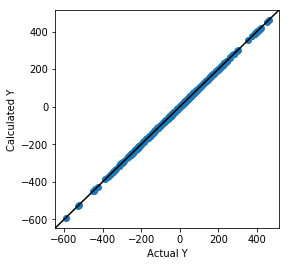

In [12]:
# Calculate y of trainig dataset
calculatedytrain = np.ndarray.flatten( regressionmodel.predict(autoscaledXtrain) )
calculatedytrain = calculatedytrain*ytrain.std(ddof=1) + ytrain.mean()
# r2, RMSE, MAE
print( "r2: {0}".format(float( 1 - sum( (ytrain-calculatedytrain )**2 ) / sum((ytrain-ytrain.mean())**2) )) )
print( "RMSE: {0}".format(float( ( sum( (ytrain-calculatedytrain)**2 )/ len(ytrain))**0.5 )) )
print( "MAE: {0}".format(float( sum( abs(ytrain-calculatedytrain)) / len(ytrain) )) )
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ytrain, calculatedytrain)
YMax = np.max( np.array([np.array(ytrain), calculatedytrain]))
YMin = np.min( np.array([np.array(ytrain), calculatedytrain]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Calculated Y")
plt.show()

r2midknn: 0.9959294627373401
RMSEmidknn: 14.069998220860205
MAEmidknn: 10.35265795740488


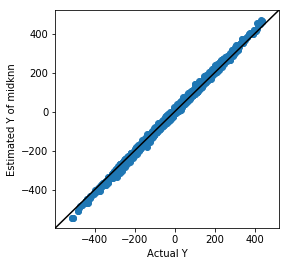

In [13]:
# Estimate y of midknn
estimatedymidknn = np.ndarray.flatten( regressionmodel.predict(Xmidknn) )
estimatedymidknn = estimatedymidknn*ytrain.std(ddof=1) + ytrain.mean()
# r2cv, RMSEcv, MAEcv
print( "r2midknn: {0}".format(float( 1 - sum( (ymidknn-estimatedymidknn )**2 ) / sum((ymidknn-ymidknn.mean())**2) )) )
print( "RMSEmidknn: {0}".format(float( ( 2*(len(ytrain)+1) * sum( (ymidknn-estimatedymidknn)**2 ) / len(ytrain) / (len(ymidknn)-1)  )**0.5 ) ))
print( "MAEmidknn: {0}".format(float( sum( abs(ymidknn-estimatedymidknn)) / len(ymidknn) * (2*(len(ytrain)+1)/len(ytrain)*len(ymidknn)/(len(ymidknn)-1))**0.5)) )
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ymidknn, estimatedymidknn)
YMax = np.max( np.array([np.array(ymidknn), estimatedymidknn]))
YMin = np.min( np.array([np.array(ymidknn), estimatedymidknn]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Estimated Y of midknn")
plt.show()

r2p: 0.9606145311676186
RMSEp: 38.499826009973795
MAEp: 25.302075089848536


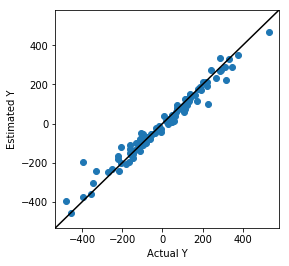

In [14]:
# Estimate y of test dataset
predictedytest = np.ndarray.flatten( regressionmodel.predict(autoscaledXtest) )
predictedytest = predictedytest*ytrain.std(ddof=1) + ytrain.mean()
# r2p, RMSEp, MAEp
print( "r2p: {0}".format(float( 1 - sum( (ytest-predictedytest )**2 ) / sum((ytest-ytest.mean())**2) )) )
print( "RMSEp: {0}".format(float( ( sum( (ytest-predictedytest)**2 )/ len(ytest))**0.5 )) )
print( "MAEp: {0}".format(float( sum( abs(ytest-predictedytest)) / len(ytest) )) )
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ytest, predictedytest)
YMax = np.max( np.array([np.array(ytest), predictedytest]))
YMin = np.min( np.array([np.array(ytest), predictedytest]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Estimated Y")
plt.show()